# Data distribution over the years

# Import Modules

In [1]:
import os
import string
import pandas as pd
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from utils import find_multipatent_compounds

tqdm.pandas()

# Add path constants

In [2]:
FIG_DIR = "../data/figures"
DATA_DIR = "../data/raw"
os.makedirs(FIG_DIR, exist_ok=True)

# Load data file

In [3]:
surechembl_df = pd.read_parquet(f"{DATA_DIR}/surechembl_dump.pq")
surechembl_df.head(2)

,SureChEMBL_ID,SMILES,InChIKey,PATENT_ID,PUBLICATION_DATE,Field
0,SCHEMBL4,C[C@H](CS)C(=O)N1CCC[C@H]1C(O)=O,FAKRSMQSSFJEIM-RQJHMYQMSA-N,EP-2842582-A2,2015-03-04,Description
1,SCHEMBL4,C[C@H](CS)C(=O)N1CCC[C@H]1C(O)=O,FAKRSMQSSFJEIM-RQJHMYQMSA-N,EP-2838373-A2,2015-02-25,Description


In [4]:
# Extract year from publication date
surechembl_df["year"] = surechembl_df["PUBLICATION_DATE"].progress_apply(
    lambda x: x.split("-")[0]
)

  0%|          | 0/133512452 [00:00<?, ?it/s]

100%|██████████| 133512452/133512452 [03:01<00:00, 735956.71it/s]


In [5]:
surechembl_df["SureChEMBL_ID"].nunique(), surechembl_df["PATENT_ID"].nunique()

(10718652, 1574602)

In [6]:
surechembl_df["SMILES"].nunique(), surechembl_df["InChIKey"].nunique()

(10718647, 10686744)

Since InchiKey is the most repliable compound representation, we choose that for finding overlaps between the datasets

# Filtering duplicate patent IDs

In [7]:
unique_patent_df = surechembl_df.drop_duplicates(
    subset=["PATENT_ID", "year"], keep="first"
)
unique_patent_df.shape

(1574604, 7)

In [8]:
# Calculate unique patents per year
patent_count_df = pd.DataFrame(unique_patent_df["year"].value_counts()).reset_index()
patent_count_df.columns = ["year", "patent_count"]
patent_count_df.sort_values("year", ascending=True, inplace=True)
patent_count_df

,year,patent_count
6,2015,188598
4,2016,200056
3,2017,203123
2,2018,207456
5,2019,194261
1,2020,220631
0,2021,222474
7,2022,138005


In [9]:
patent_count_df["patent_count"].mean()

196825.5

About 196,825 patents are filed every year.

# Calculate unique compounds per year

In [10]:
# Get repreated smile counts
compound_count_df = find_multipatent_compounds(surechembl_df)
compound_count_df["unique_compounds"].mean()

1137183.4285714286

In [11]:
# the total no.of unique compounds
compound_count_df["patented_drug_count"].mean() / compound_count_df[
    "unique_compounds"
].sum()

0.20046809887687425

0.2% compounds were found to be found to be linked with multiple patents.

In [12]:
compound_count_df

,year,patented_drug_count,unique_compounds
0,2016,1298420,1545252
1,2017,1818745,1530677
2,2018,1695482,871159
3,2019,1653234,977705
4,2020,1722031,1193276
5,2021,1779891,1220263
6,2022,1202678,621952


# Visualisation

In [13]:
sns.set_style("whitegrid")

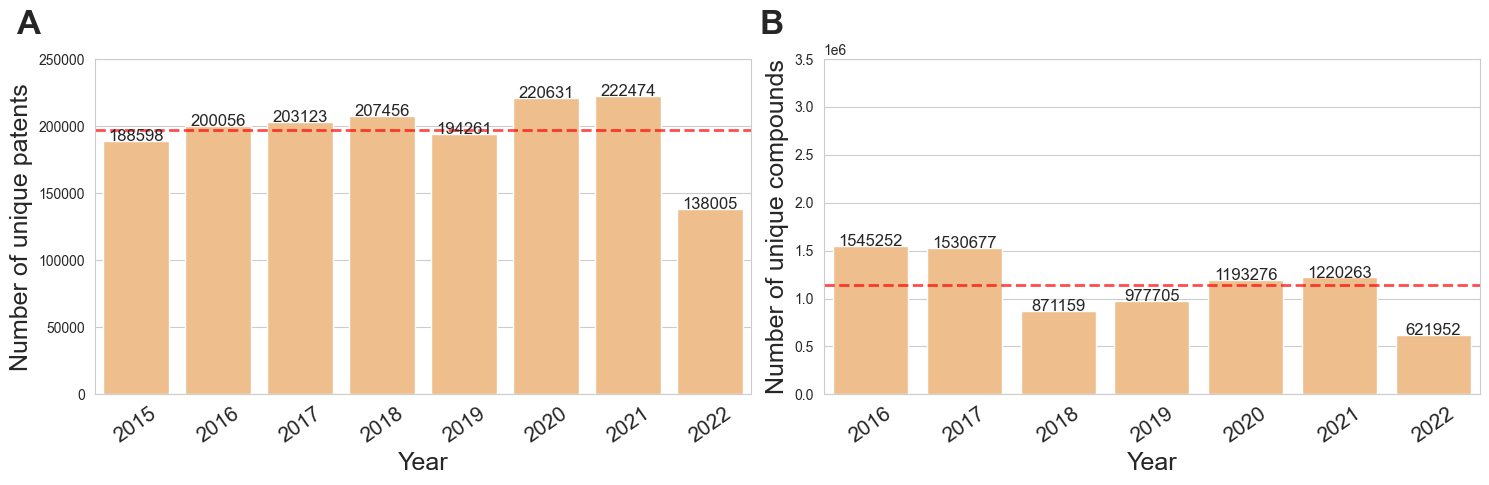

In [14]:
plt.figure(figsize=(15, 5))
patent_count_avg = patent_count_df["patent_count"].mean()

plt.subplot(1, 2, 1)
ax1 = sns.barplot(data=patent_count_df, x="year", y="patent_count", color="#ffbe7d")
ax1.axhline(patent_count_avg, linewidth=2, color="r", linestyle="--", alpha=0.7)
plt.xlabel("Year", fontsize=18)
plt.ylabel("Number of unique patents", fontsize=18)
plt.xticks(rotation=35, fontsize=15)
plt.ylim(top=250000)

# Show counts on top of plot
for p in ax1.patches:
    _x = p.get_x() + p.get_width() / 2
    _y = p.get_y() + p.get_height() + 50
    value = int(p.get_height())
    ax1.text(_x, _y, value, ha="center", fontsize=12)

plt.text(
    -0.1,
    1.1,
    string.ascii_uppercase[0],
    size=24,
    weight="bold",
    horizontalalignment="center",
    verticalalignment="center",
    transform=plt.gca().transAxes,
)

cpds_count_avg = compound_count_df["unique_compounds"].mean()

plt.subplot(1, 2, 2)
ax2 = sns.barplot(
    data=compound_count_df, x="year", y="unique_compounds", color="#ffbe7d"
)
ax2.axhline(cpds_count_avg, linewidth=2, color="r", linestyle="--", alpha=0.7)
plt.xlabel("Year", fontsize=18)
plt.ylabel("Number of unique compounds", fontsize=18)
plt.xticks(rotation=35, fontsize=15)
plt.ylim(top=3500000)

for p in ax2.patches:
    _x = p.get_x() + p.get_width() / 2
    _y = p.get_y() + p.get_height() + 50
    value = int(p.get_height())
    ax2.text(_x, _y, value, ha="center", fontsize=12)

plt.text(
    -0.08,
    1.1,
    string.ascii_uppercase[1],
    size=24,
    weight="bold",
    horizontalalignment="center",
    verticalalignment="center",
    transform=plt.gca().transAxes,
)

plt.tight_layout()
plt.savefig(f"{FIG_DIR}/figure_1.png", dpi=400)
plt.show()

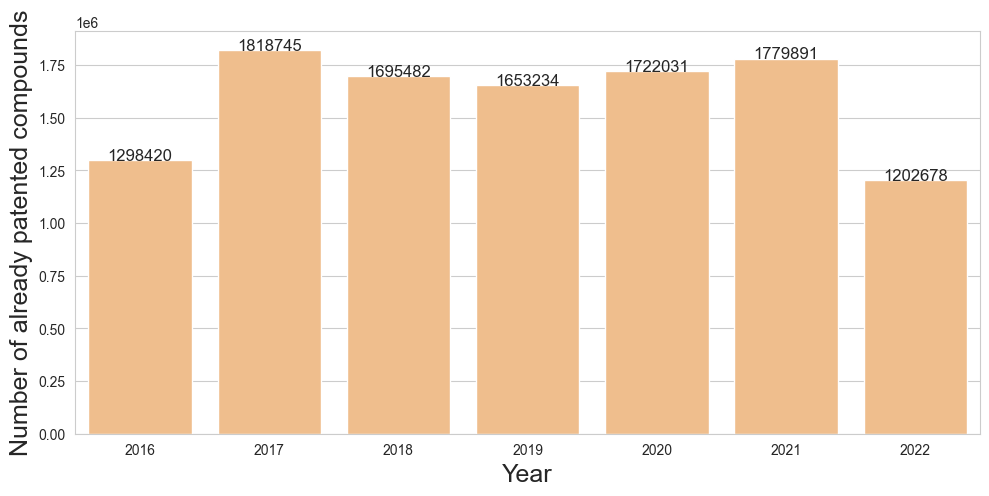

In [15]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(
    data=compound_count_df, x="year", y="patented_drug_count", color="#ffbe7d"
)

for p in ax.patches:
    _x = p.get_x() + p.get_width() / 2
    _y = p.get_y() + p.get_height() + 50
    value = int(p.get_height())
    ax.text(_x, _y, value, ha="center", fontsize=12)

plt.xlabel("Year", fontsize=18)
plt.ylabel("Number of already patented compounds", fontsize=18)
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/supplementary_figure_1.png", dpi=400)
plt.show()